# Домашнее задание #1 CVR

## Детекция груза, заполнение массивов времени и координат центра груза

In [ ]:
import cv2
import numpy as np
import time

cv2.namedWindow('mask')

cam = cv2.VideoCapture(1, cv2.CAP_DSHOW)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

t = []
x = []
y = []

start_experiment = time.time()

while (time.time() - start_experiment < 120): #2 минут колебаний
    success, frame = cam.read()
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0, 111, 158), (117, 226, 243))
     
    kernel = np.ones((4, 4), np.uint8)
    morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    connectivity = 4  
    output = cv2.connectedComponentsWithStats(morph, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    
    filtered = np.zeros_like(mask)
    
    for i in range(1, num_labels):
        a = stats[i, cv2.CC_STAT_AREA]
        top = stats[i, cv2.CC_STAT_TOP]
        left = stats[i, cv2.CC_STAT_LEFT]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        center_x = left + width // 2
        center_y = top + height // 2
        
        if (a >= 6000):
            filtered[np.where(labels == i)] = 255
            
            
            cv2.putText(frame, str(f"({center_x}, {center_y})"), (left, top - 30), cv2.FONT_ITALIC, 1, (0, 0, 255), 2, cv2.LINE_4)
            cv2.circle(frame, (center_x, center_y), 4, (0, 0, 255), 3)
            cv2.rectangle(frame, (left, top), (left + width, top + height), (0, 255, 0), 1)
            
            if num_labels > 1:
                t.append(time.time() - start_experiment)
                x.append((center_x))
                y.append((center_y))
    
    cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
    cv2.imshow('custom window', frame)
    cv2.resizeWindow('custom window', 1280, 720)
    
    key = cv2.waitKey(30) & 0xFF
    
    if (key == ord('q')):
        break

cam.release()
cv2.destroyAllWindows()
cv2.waitKey(10)

-1

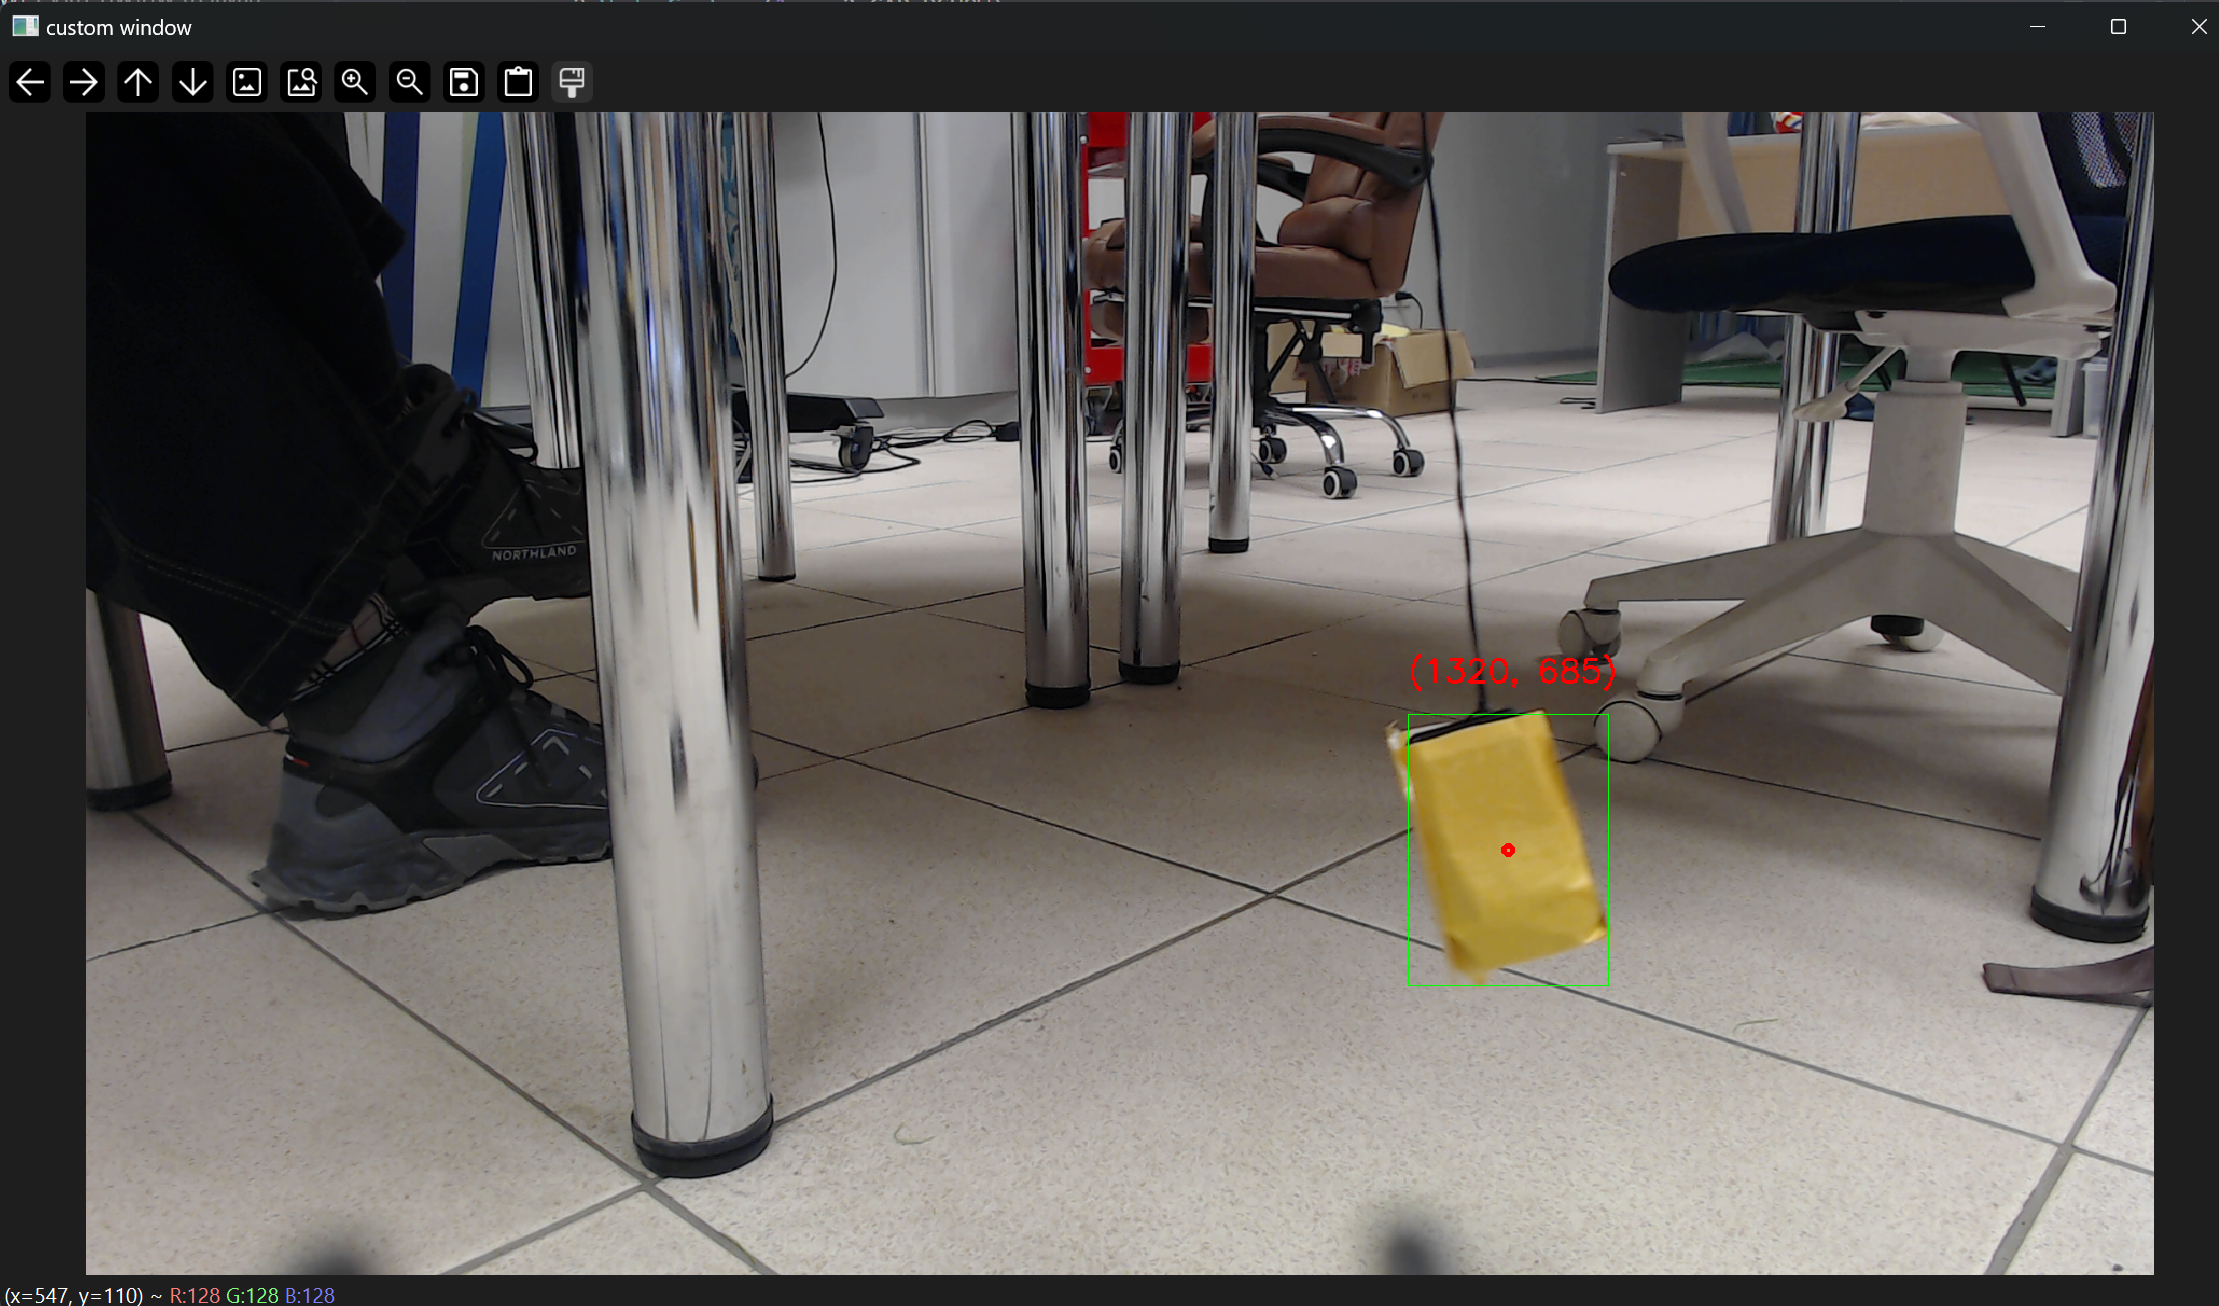

## Полученные экспериментальные точки

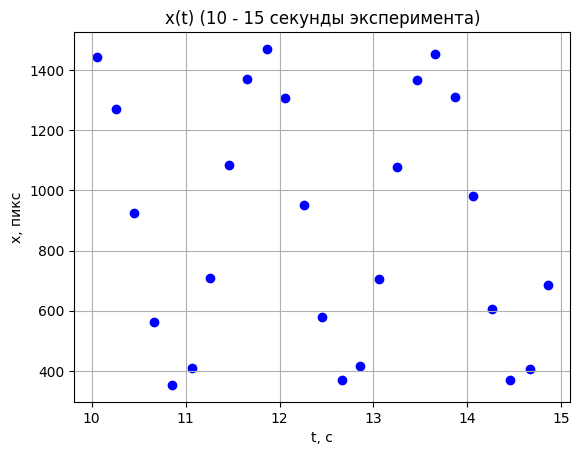

In [99]:
import numpy as np
import matplotlib.pyplot as plt

t_plt = np.array([t[i] for i in range(len(t)) if 10 < t[i] <= 15])
x_plt = np.array([x[i] for i in range(len(t)) if 10 < t[i] <= 15])

plt.scatter(t_plt, x_plt, label='x(t)', color='blue')
plt.xlabel('t, с')
plt.ylabel('x, пикс')
plt.title('x(t) (10 - 15 секунды эксперимента)')
plt.grid(True)
plt.show()



## Нахождение частоты колебаний, Быстрое преобразование Фурье

Максимальная частота после 0.025 Гц: 0.55 Гц, амплитуда: 111544.11


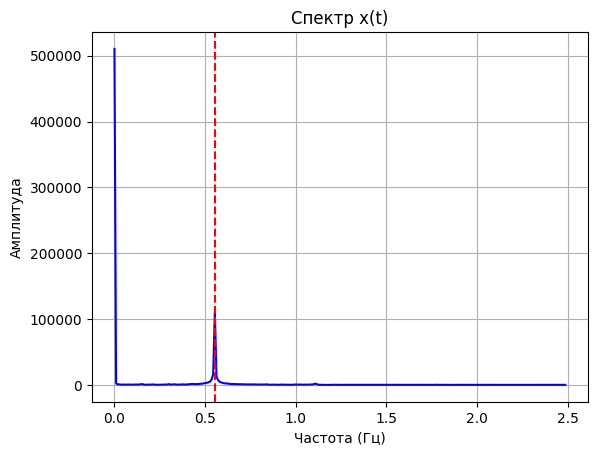

In [97]:

from scipy.fft import fft, fftfreq

# Фильтрация значений
t_filtered = np.array([t[i] for i in range(len(t)) if t[i] > 10])
x_filtered = np.array([x[i] for i in range(len(t)) if t[i] > 10])

N = len(t_filtered)
T = np.mean(np.diff(t_filtered))

xf = fftfreq(N, T)[:N//2]
yf_x = np.abs(fft(x_filtered))[:N//2]

# Максимум частоты после 0.025 Гц
valid_indices = np.where(xf > 0.025)[0]
max_idx = valid_indices[np.argmax(yf_x[valid_indices])]
max_freq = xf[max_idx]
max_amplitude = yf_x[max_idx]

print(f"Максимальная частота после 0.025 Гц: {max_freq:.2f} Гц, амплитуда: {max_amplitude:.2f}")

# График спектра x(t)
plt.plot(xf, yf_x, label='Спектр x(t)', color='blue')
plt.axvline(max_freq, color='red', linestyle='--')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.title('Спектр x(t)')
plt.grid(True)
plt.show()


## Расчет ускорения свободного падения

In [98]:
L = 0.78 + 0.03 # Длина нити + расстояние до центра масс груза
g = (2 * np.pi * max_freq) ** 2 * L
print(f'Ускорение свободного падения: {g:.4f} м/с^2')

Ускорение свободного падения: 9.7982 м/с^2
